In [1]:
import sys
sys.path.append('/home/wangs/rs/lib')
import ff
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
sns.set_palette("pastel")
from multiprocessing import Pool
from tqdm import tqdm

In [ ]:
def plot_minute_return_curve(return_series, title="6天分钟级累计收益曲线", figsize=(12, 6)):
    """
    绘制6天（1440分钟）的累计收益曲线，仅显示分钟序号和累计收益率
    
    参数:
    return_series: pd.Series，长度为1440的分钟级收益率数据
    title: 图表标题
    figsize: 图表尺寸
    """
    # 检查数据长度（6天×240分钟=1440）
    if len(return_series) != 1440:
        raise ValueError(f"输入数据长度必须为1440（6天×240分钟），当前为{len(return_series)}")
    
    # 计算累计收益率（从0开始）
    cumulative_return = (1 + return_series).cumprod() - 1
    
    # 创建分钟序号索引（0-1439）
    minute_index = np.arange(1440)
    
    # 创建画布
    plt.figure(figsize=figsize)
    ax = plt.gca()
    
    # 绘制累计收益曲线
    ax.plot(
        minute_index,
        cumulative_return,
        color="#2c7fb8",
        linewidth=1.2,
        label="累计收益率"
    )
    
    # 每天分隔线（第240、480、720、960、1200分钟处）
    for day in range(1, 6):
        ax.axvline(
            x=day * 240,
            color="gray",
            linestyle="--",
            alpha=0.5,
            label="每天分隔线" if day == 1 else ""  # 仅第一个分隔线显示标签
        )
    
    # 坐标轴设置
    ax.set_xlabel("分钟序号（0-1439）", fontsize=10)
    ax.set_ylabel("累计收益率", fontsize=10)
    ax.set_title(title, fontsize=12, pad=20)
    
    # x轴刻度按天显示（每天240分钟）
    ax.set_xticks([i * 240 for i in range(7)])
    ax.set_xticklabels([f"第{i}天" for i in range(7)])  # 0-6对应6天的起点
    
    # 网格和图例
    ax.grid(linestyle="--", alpha=0.5)
    ax.legend(loc="best")
    
    plt.tight_layout()
    return plt.gcf()

In [108]:
def plot_multi_columns_return(df, title="多列收益对比图", 
                              colors=None, figsize=(14, 8),
                              show_daily_dividers=True,
                              cumulative=True):
    """
    绘制DataFrame中多列收益数据的对比图
    
    参数:
    df: pd.DataFrame，包含多列收益数据
    title: str，图表标题
    colors: list，自定义每列的颜色
    figsize: tuple，图表尺寸
    show_daily_dividers: bool，是否显示每日分隔线
    cumulative: bool，是否绘制累计收益（否则绘制瞬时收益）
    
    返回:
    plt.Figure: 图表对象
    """
    # 检查数据形状
    if df.shape[0] != 1440:
        raise ValueError(f"输入的DataFrame必须有1440行（代表6天分钟数据），当前行数是{df.shape[0]}")
    
    # 创建画布
    plt.figure(figsize=figsize)
    
    # 默认颜色（如果未提供）
    if colors is None:
        colors = plt.cm.rainbow(np.linspace(0, 1, df.shape[1]))
    
    # 绘制每一列的收益曲线
    for i, col in enumerate(df.columns):
        # 根据参数选择绘制累计收益或瞬时收益
        if cumulative:
            values = (1 + df[col]).cumprod() - 1
            y_label = '累计收益率'
        else:
            values = df[col]
            y_label = '瞬时收益率'
        
        # 绘制曲线（使用DataFrame的列名作为图例）
        plt.plot(range(1440), values, 
                 label=col,  # 直接使用列名作为图例
                 color=colors[i], 
                 linewidth=1.5,
                 alpha=0.8)
    
    # 添加每天的分隔线（240分钟为一天）
    if show_daily_dividers:
        for day in range(1, 6):
            plt.axvline(x=day*240, color='gray', linestyle='--', alpha=0.5)
    
    # 设置图表属性
    plt.title(title, fontsize=14)
    plt.xlabel('分钟序号', fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    
    # 设置x轴刻度（每天的起始点）
    plt.xticks([i*240 for i in range(7)], [f'第{i}天' for i in range(7)], fontsize=10)
    
    # 添加网格和图例（使用DataFrame的列名）
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    
    # 优化布局
    plt.tight_layout()
    
    return plt.gcf()

In [3]:
def ret_data():
    close_data = pd.read_pickle("/mydata2/wangs/data/fmins/close.pk")
    pre_close_data = close_data.shift(1)
    ret_data = (close_data - pre_close_data) / pre_close_data
    ret_data.index = pd.to_datetime(ret_data.index)
    return ret_data

In [113]:
pd.read_pickle("/mydata2/wangs/data/fmins/close.pk")

,000001.SZ,000002.SZ,000004.SZ,000006.SZ,000007.SZ,000008.SZ,000009.SZ,000010.SZ,000011.SZ,000012.SZ,...,600978.SH,601258.SH,601558.SH,603133.SH,603157.SH,603555.SH,603603.SH,603996.SH,688086.SH,688555.SH
2020-01-02 09:31:00,16.70,33.01,22.85,5.42,9.55,3.66,6.26,3.40,9.49,5.03,...,3.00,1.42,1.10,24.88,5.80,5.91,9.14,4.91,NaN,NaN
2020-01-02 09:32:00,16.83,33.10,22.78,5.41,9.48,3.65,6.21,3.41,9.45,5.04,...,2.99,1.42,1.09,25.10,5.78,5.84,9.25,4.91,NaN,NaN
2020-01-02 09:33:00,16.77,33.18,22.70,5.42,9.46,3.65,6.27,3.42,9.44,5.05,...,3.00,1.41,1.09,25.11,5.80,5.89,9.22,4.91,NaN,NaN
2020-01-02 09:34:00,16.80,33.44,22.49,5.42,9.50,3.64,6.26,3.42,9.45,5.08,...,3.00,1.41,1.09,24.95,5.81,5.98,9.25,4.91,NaN,NaN
2020-01-02 09:35:00,16.80,33.49,22.43,5.44,9.50,3.64,6.27,3.41,9.46,5.07,...,2.99,1.39,1.09,24.84,5.78,6.00,9.27,4.93,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-05 14:56:00,11.43,8.50,18.31,9.01,7.15,3.71,9.85,3.17,9.81,5.56,...,0.52,0.40,0.25,0.29,0.59,0.67,0.39,0.39,0.64,1.12
2024-12-05 14:57:00,11.44,8.51,18.28,9.02,7.15,3.71,9.86,3.17,9.83,5.55,...,0.52,0.40,0.25,0.29,0.59,0.67,0.39,0.39,0.64,1.12
2024-12-05 14:58:00,11.44,8.51,18.28,9.02,7.15,3.71,9.86,3.17,9.83,5.55,...,0.52,0.40,0.25,0.29,0.59,0.67,0.39,0.39,0.64,1.12
2024-12-05 14:59:00,11.44,8.51,18.28,9.02,7.15,3.71,9.86,3.17,9.83,5.55,...,0.52,0.40,0.25,0.29,0.59,0.67,0.39,0.39,0.64,1.12


In [4]:
def process_indicator(data, indicator_name):
        # stack()：将列（股票ID）转为行，形成（时间, 股票ID）的二级索引
        long_df = data.stack().reset_index()
        # 重命名列：股票ID、时间、指标值
        long_df.columns = ['stock_id', 'time', 'value']
        # 添加指标类型列（如'post'、'high'）
        long_df['indicator'] = indicator_name
        return long_df

In [5]:
###预处理 拼成长表
post_data = ff.read('post') * ff.filter0
high_data = ff.read('high') * post_data * ff.filter0
low_data = ff.read('low') * post_data * ff.filter0
close_data = ff.read('close') * post_data * ff.filter0
open_data = ff.read('open') * post_data * ff.filter0
uplimit_data = ff.read('up_limit') * post_data * ff.filter0
   
df_post = process_indicator(post_data, 'post')
df_high = process_indicator(high_data, 'high')
df_low = process_indicator(low_data, 'low')
df_close = process_indicator(close_data, 'close')
df_open = process_indicator(open_data, 'open')
df_uplimit = process_indicator(uplimit_data, 'uplimit')

long_table = pd.concat(
    [df_high, df_low, df_close, df_open, df_uplimit],
    ignore_index=True
)
    
##并行处理所有股票数据
stock_list = long_table['stock_id'].unique()    

In [14]:
def init_worker(table):
    global shared_table
    shared_table = table

init_worker(long_table)

In [7]:
def climax_find(df):
    '''
    找到局部极值点
    ##输入：DataFrame index是日期 columns是high low open close
    ##输出：DataFrame index是日期 columns是high low open close peak
    # 创建peak列，默认值为NaN
    '''
    
    df['peak'] = np.nan
    
    for i in range(len(df)):
        # 确定查找范围（防止越界）
        start = max(0, i - 1)
        end = min(len(df), i + 2)
        
        # 使用loc通过标签索引列
        current_high = df.loc[df.index[i], 'high']
        range_highs = df.loc[df.index[start:end], 'high']
        
        # 判断当前是否为局部高点
        if current_high == range_highs.max():
            df.loc[df.index[i], 'peak'] = 'high'
            continue  # 找到高点后继续下一个点
            
        # 判断当前是否为局部低点
        current_low = df.loc[df.index[i], 'low']
        range_lows = df.loc[df.index[start:end], 'low']
        
        if current_low == range_lows.min():
            df.loc[df.index[i], 'peak'] = 'low'
    
    return df

In [8]:
def platform_find(df):
    """
    查找价格平台（以当前K线为最新K线的平台高点）
    
    参数:
    df (pd.DataFrame): 包含K线数据的DataFrame，索引可为任意类型，
                      列包含'high', 'low', 'open', 'close', 'peak'
    
    返回:
    pd.DataFrame: 添加了'platform'列的DataFrame，记录平台高点和平台长度
    """
    # 创建platform列，默认值为NaN
    df['platform'] = np.nan
    df['platform_length'] = np.nan
    
    # 获取列的位置索引（确保兼容任意索引类型）
    peak_col = df.columns.get_loc('peak')
    low_col = df.columns.get_loc('low')
    high_col = df.columns.get_loc('high')
    
    # 遍历每一行（从第1行开始，0-based索引）
    for i in range(1, len(df)):
        current_high_low = None  # 最近高点对应的低点
        current_low_high = None  # 最近低点对应的高点
        
        # 向前查找（从i-1到0）
        for j in range(i-1, -1, -1):
            # 使用iloc按位置访问，避免索引类型问题
            peak_val = df.iloc[j, peak_col]
            
            if peak_val == 'high':
                current_high_low = df.iloc[j, low_col]
            elif peak_val == 'low':
                current_low_high = df.iloc[j, high_col]
            
            # 当同时找到有效高点和低点，且满足高低点条件时
            if (current_high_low is not None and 
                current_low_high is not None and 
                current_high_low < current_low_high):
                
                # 计算j到i区间内的最高值作为平台高点
                platform_high = df.iloc[j:i, high_col].max()
                df.iloc[i, df.columns.get_loc('platform')] = platform_high
                df.iloc[i, df.columns.get_loc('platform_length')] = i - j
                break  # 找到平台后跳出内层循环
    
    return df

In [48]:
def run(df, start_date, end_date,stock_id):
    """
    回测函数（按platform_length分类计算）
    输入：DataFrame 对应一支股票，index是日期，columns包含 high, low, open, close, platform, uplimit, platform_length
    输出：dict 键为分类（'2','3','4','5','6','≥7'），值为元组 (cat_infp_list, count)
    """
    # 1. 筛选基础符合条件的交易日（包含platform_length）
    valid_days = df[
        (df['high'] > df['platform']) & 
        (df['uplimit'] != df['close']) &
        (df.index >= start_date) & 
        (df.index <= end_date) &
        (df['platform_length'].notna())  # 确保platform_length非空
    ]
    
    # 2. 定义6个分类的条件（键为分类名称，值为筛选条件）
    categories = {
        '2': valid_days['platform_length'] == 2,
        '3': valid_days['platform_length'] == 3,
        '4': valid_days['platform_length'] == 4,
        '5': valid_days['platform_length'] == 5,
        '6': valid_days['platform_length'] == 6,
        '≥7': valid_days['platform_length'] >= 7
    }
    
    # 3. 初始化每个分类的结果容器
    result_dict = {}
    for cat in categories.keys():
        # 初始化
        result_dict[cat] = ([],0)
    
    # 4. 遍历每个分类，计算结果
    for cat, condition in categories.items():
        # 筛选当前分类下的交易日
        cat_days = valid_days[condition]
        if cat_days.empty:
            continue  # 该分类无数据，跳过
        
        # 初始化当前分类的累加结果和计数
        cat_count = 0
        cat_info_list = []
        
        # 遍历当前分类的每个交易日
        for idx in cat_days.index:
            # 获取当前交易日在df中的位置索引
            try:
                t = df.index.get_loc(idx)
            except KeyError:
                continue  # 索引不匹配，跳过
            
            # 归一化并累加结果
            cat_count += 1
            cat_info_list.append((stock_id,idx))
        # 存储当前分类的结果（result, count）
        result_dict[cat] = (cat_info_list, cat_count)
    
    return result_dict

In [16]:
def stock_process(stock_id,start_date = '2020-01-03',end_date = '2024-12-01'):
    ##输入：单只股票的DataFrame index:日期 columns：高开低收
    ##输出：单只股票用于画Kline的DataFrame
    df = shared_table[shared_table['stock_id'] == stock_id]
    stock_data = df.pivot(index='time',
                        columns='indicator',
                        values='value')
    stock_data.index = pd.to_datetime(stock_data.index)
    stock_data = climax_find(stock_data)
    stock_data = platform_find(stock_data)
    res_dict = run(stock_data,start_date,end_date,stock_id)
    return res_dict

In [11]:
return_data = ret_data()


In [45]:
test = stock_process('000020.SZ')

In [86]:
def minute_data_extract(tumple,return_data):
    result = pd.Series(0,index = range(240*6))
    valid_count = 0
    for item in tumple[0]:
        start_time_index = return_data.index.get_loc(item[1].replace(hour = 9,minute = 31,second = 0,microsecond = 0))
        slice_data = return_data.iloc[start_time_index:start_time_index + 240 * 6][item[0]].reset_index(drop = True)
        if slice_data.hasnans:
            continue
        result += slice_data
        valid_count += 1
    return result / valid_count if valid_count > 0 else result

In [90]:
def minute_data_extract(tumple):
    global GLOBAL_RETURN_DATA
    """
    提取分钟级数据并累加有效样本，跳过包含NaN的切片

    参数:
    tumple: 元组 (info_list, count)，其中info_list包含(stock_id, 突破日期)
    return_data: DataFrame，包含分钟级数据，索引为时间戳
    
    返回:
    pd.Series: 累加并平均后的结果
    """
    result = pd.Series(0, index=range(240*6))  # 初始化结果容器
    valid_count = 0  # 有效样本计数器

    for item in tumple[0]:
        stock_id, break_date = item

        # 计算起始时间（突破日的9:31）
        start_time = break_date.replace(hour=9, minute=31, second=0, microsecond=0)

        # 检查起始时间是否在return_data索引中
        if start_time not in GLOBAL_RETURN_DATA.index:
            continue

        # 计算结束时间（6天后）
        end_time_idx = return_data.index.get_loc(start_time) + 240*6 - 1

        # 检查结束索引是否越界
        if end_time_idx >= len(return_data):
            continue

        # 获取结束时间戳
        end_time = return_data.index[end_time_idx]

        # 提取切片（使用loc确保时间戳存在）
        try:
            slice_data = return_data.loc[start_time:end_time, stock_id].copy()
        except KeyError:
            continue  # 股票ID不存在，跳过

        # 重置索引并验证长度
        slice_data = slice_data.reset_index(drop=True)
        if len(slice_data) != 240*6:
            continue  # 数据长度不足，跳过

        # 检查是否存在NaN
        if slice_data.hasnans:
            continue  # 包含NaN，跳过

        # 累加有效数据
        result += slice_data
        valid_count += 1

    # 返回平均值（避免除以0）
    return result / valid_count if valid_count > 0 else result

In [92]:
# 全局变量
GLOBAL_RETURN_DATA = None

def minute_data_extract(tumple):
    """直接使用全局变量 GLOBAL_RETURN_DATA 的处理函数"""
    global GLOBAL_RETURN_DATA  # 声明使用全局变量
    
    result = pd.Series(0, index=range(240*6))
    valid_count = 0
    
    for item in tumple[0]:
        # 与原函数逻辑相同...
        stock_id, break_date = item
        start_time = break_date.replace(hour=9, minute=31, second=0, microsecond=0)
        
        if start_time not in GLOBAL_RETURN_DATA.index:
            continue
            
        end_time_idx = GLOBAL_RETURN_DATA.index.get_loc(start_time) + 240*6 - 1
        if end_time_idx >= len(GLOBAL_RETURN_DATA):
            continue
            
        end_time = GLOBAL_RETURN_DATA.index[end_time_idx]
        
        try:
            slice_data = GLOBAL_RETURN_DATA.loc[start_time:end_time, stock_id].copy()
        except KeyError:
            continue
            
        slice_data = slice_data.reset_index(drop=True)
        if len(slice_data) != 240*6 or slice_data.hasnans:
            continue
            
        result += slice_data
        valid_count += 1
    
    return result / valid_count if valid_count > 0 else result

In [ ]:
se = minute_data_extract(test['5'],return_data)

处理进度: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:50<00:00,  5.05s/it]


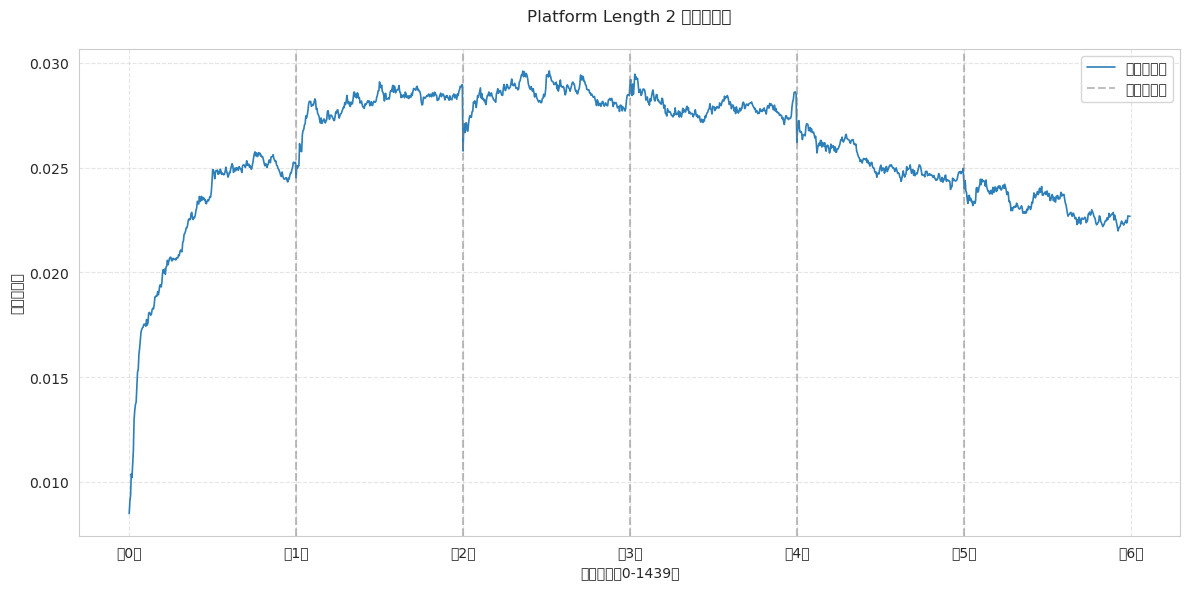

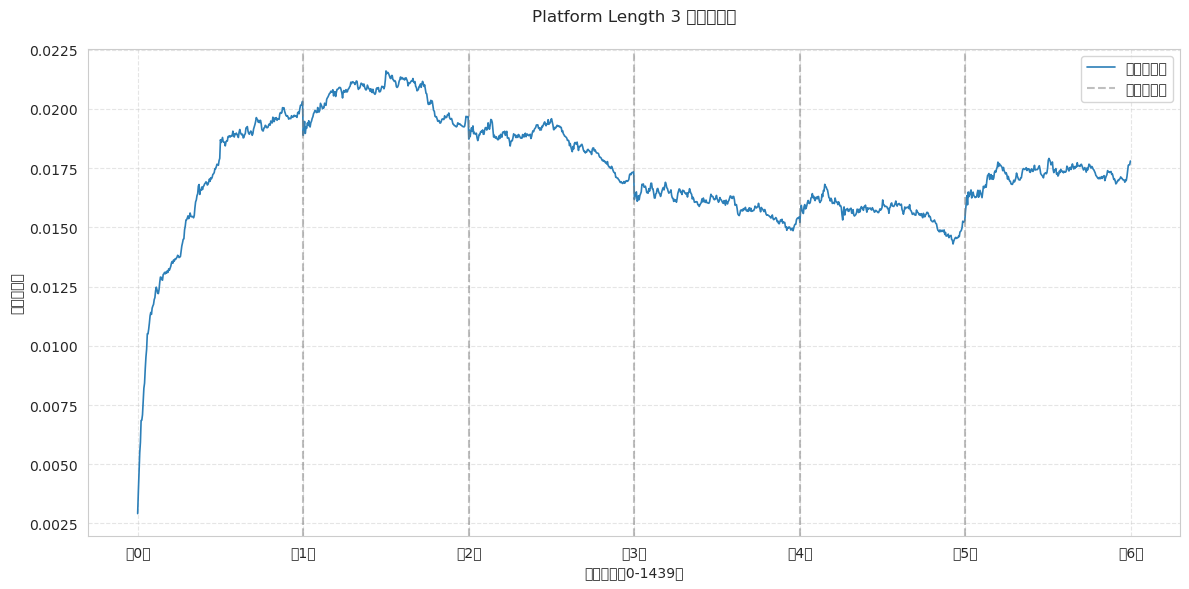

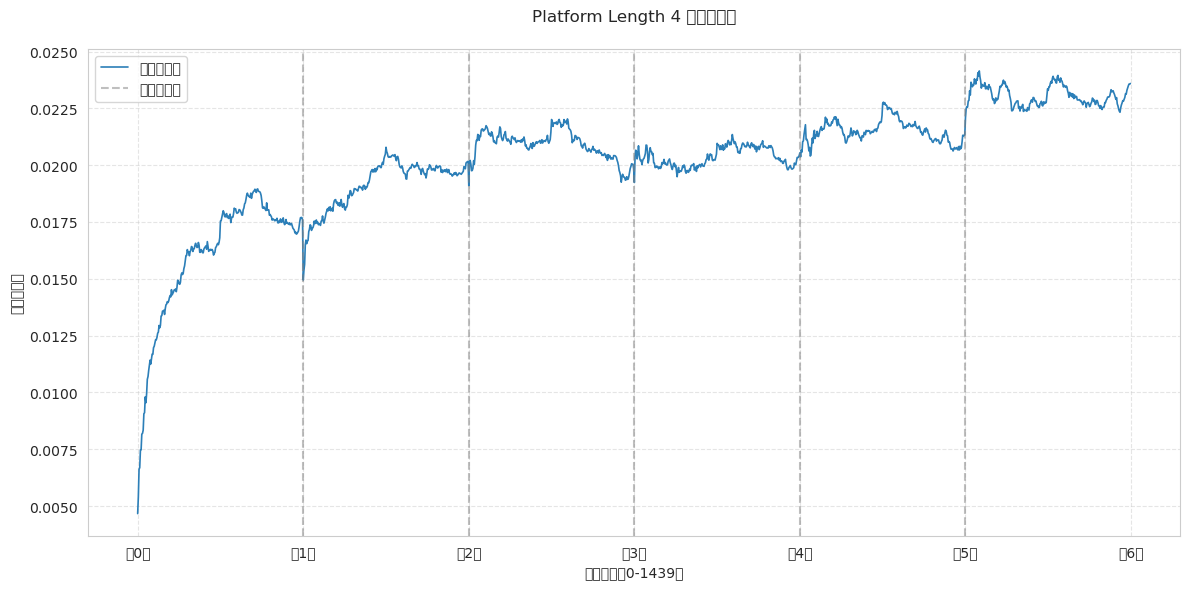

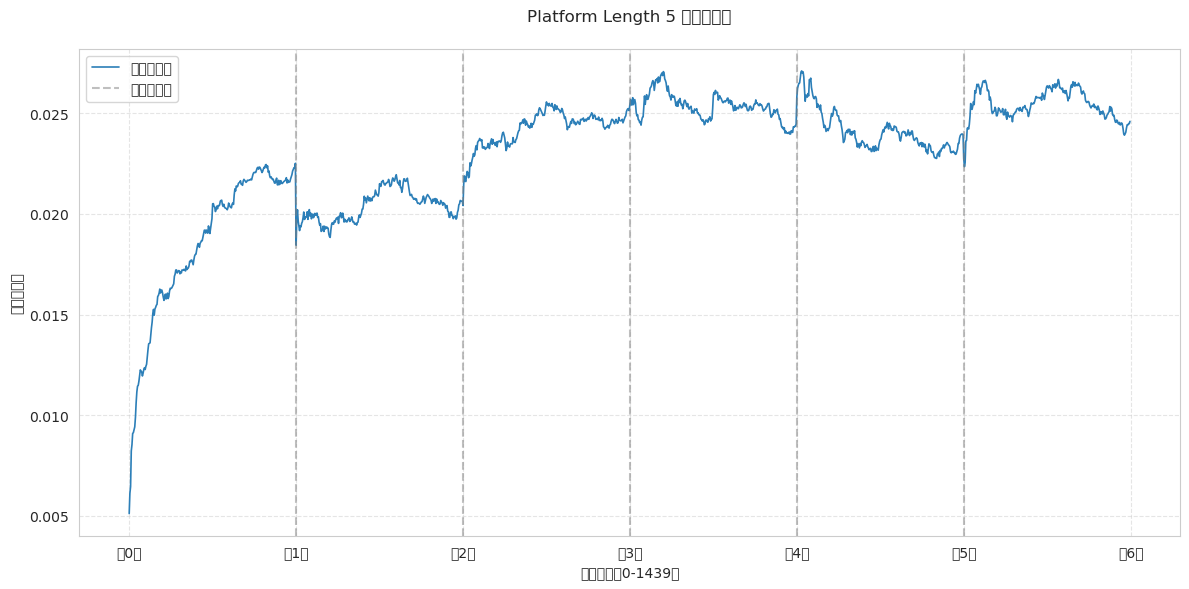

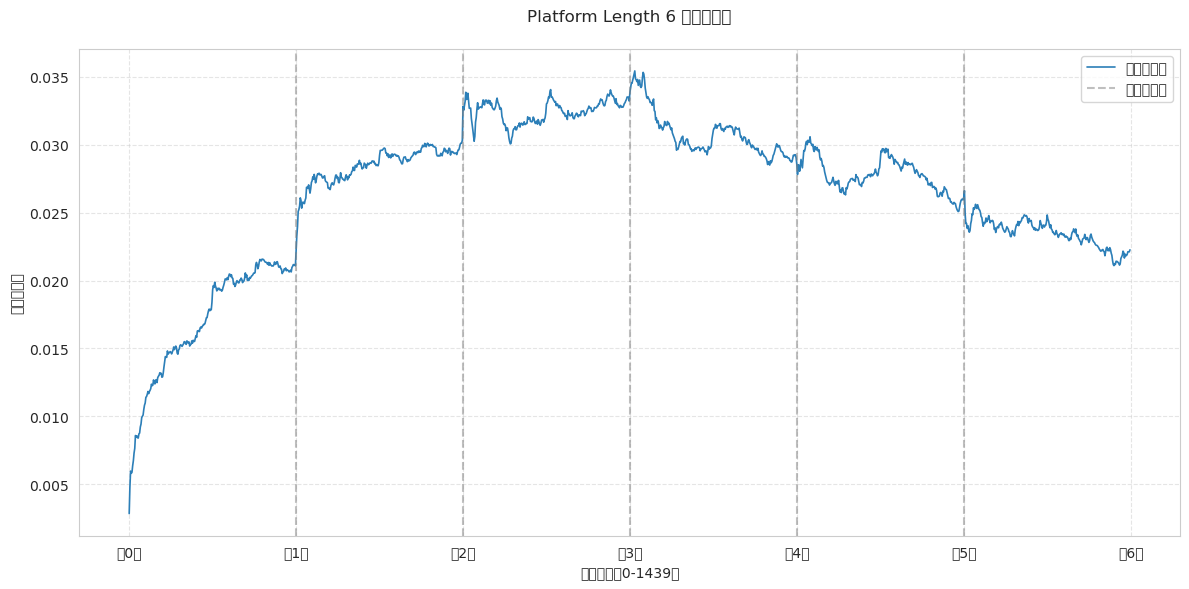

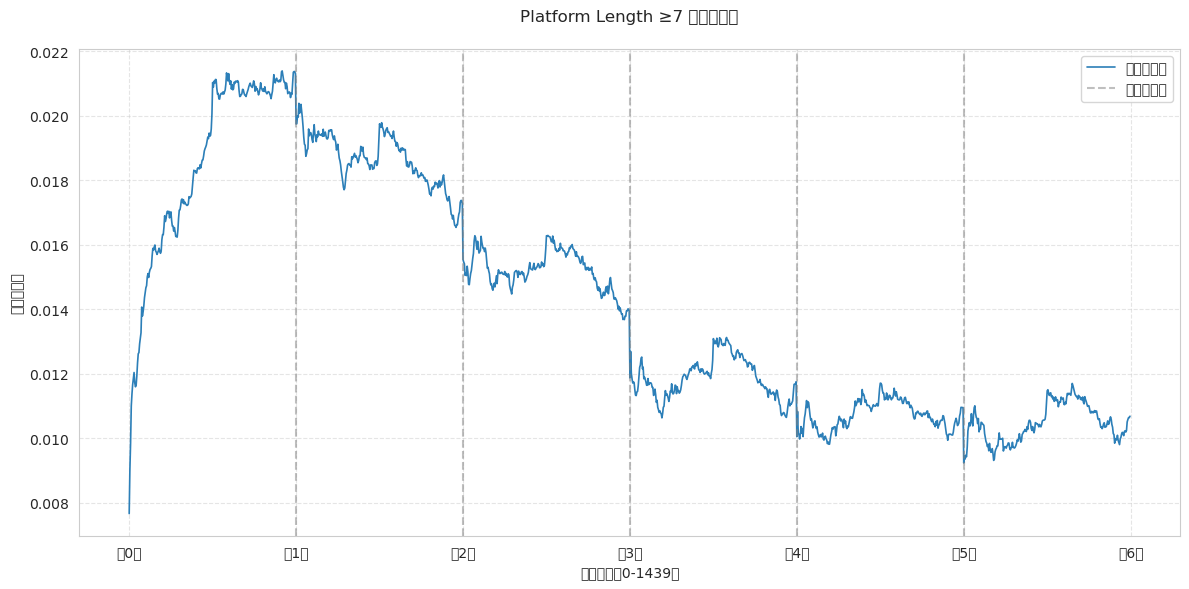

In [94]:
import random

stock_list_test = random.sample(stock_list.tolist(),10)
# 初始化结果字典
final = {'2':[[],0],'3':[[],0],'4':[[],0],'5':[[],0],'6':[[],0],'≥7':[[],0]}

# 串行处理每支股票（替代原有的多进程）
res_lst = []
for stock_id in tqdm(aaa, desc="处理进度"):
    result = stock_process(stock_id)  # 直接调用处理函数
    res_lst.append(result)

# 合并所有结果
for t in res_lst:
    for key, values in t.items():
        final[key][0].extend(values[0])  # 合并列表
        final[key][1] += values[1]       # 累加计数
GLOBAL_RETURN_DATA = return_data  # 赋值一次
# 提取数据并绘图
return_ppdd = pd.DataFrame(0,index = range(240*6),columns = ['2','3','4','5','6','≥7'])
for i in ['2', '3', '4', '5', '6', '≥7']:
    s = minute_data_extract(final[i])
    return_ppdd[i] = s
    plot_minute_return_curve(s, title=f"Platform Length {i} 的收益曲线")
    plt.show()
    

In [95]:
return_ppdd

,2,3,4,5,6,≥7
0,8.477576e-03,0.002915,0.004669,0.005120,0.002830,0.007667
1,5.823603e-04,0.000923,0.000744,0.000997,0.001908,0.001349
2,2.709743e-04,0.000764,0.001192,0.000334,0.001211,0.000821
3,1.025116e-03,0.000872,0.000076,0.001760,-0.000161,0.001136
4,-1.730203e-04,0.000444,0.000768,0.000310,0.000073,0.000373
...,...,...,...,...,...,...
1435,2.122299e-05,0.000259,0.000100,0.000153,0.000084,0.000265
1436,3.103814e-04,0.000222,0.000089,-0.000010,0.000186,0.000072
1437,-1.866077e-05,0.000018,0.000076,0.000063,-0.000002,0.000059
1438,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5108/5108 [08:06<00:00, 10.50it/s]


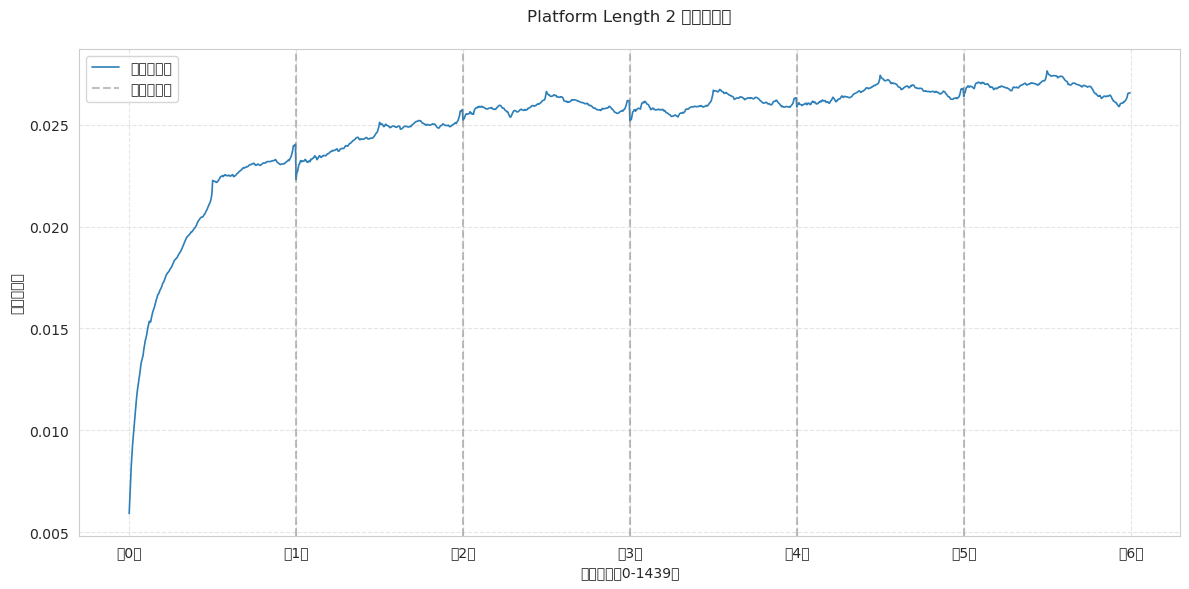

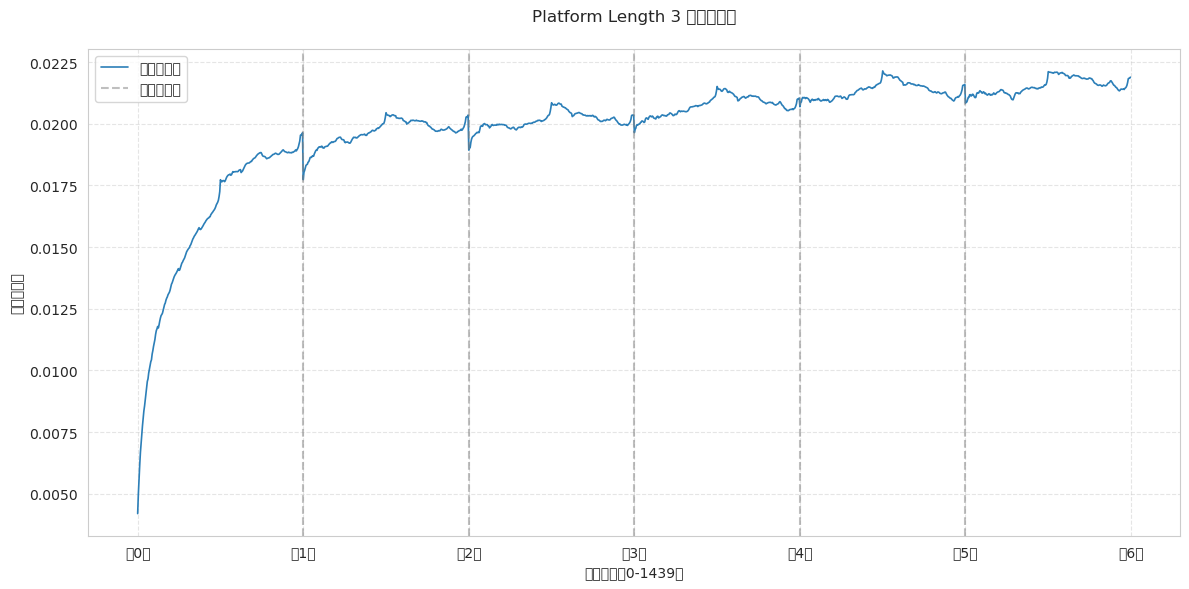

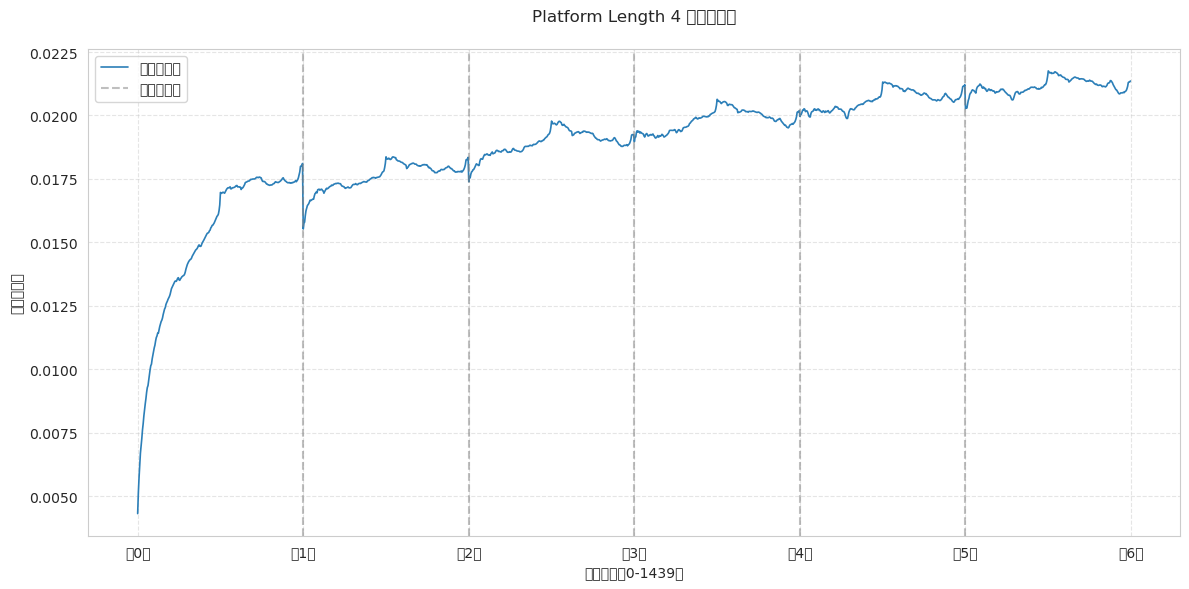

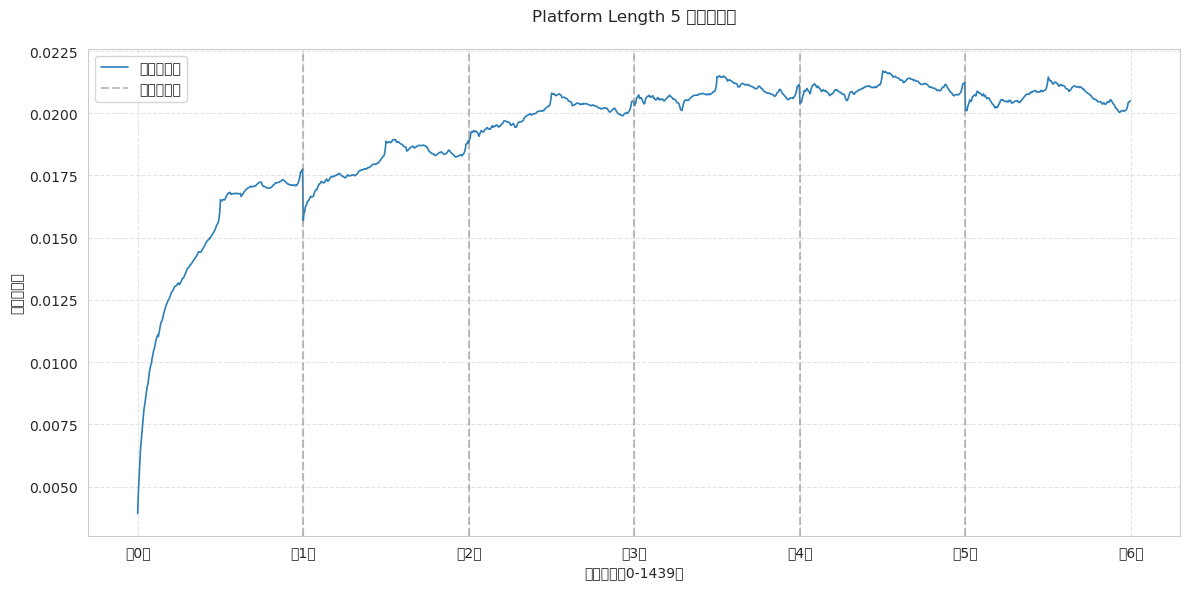

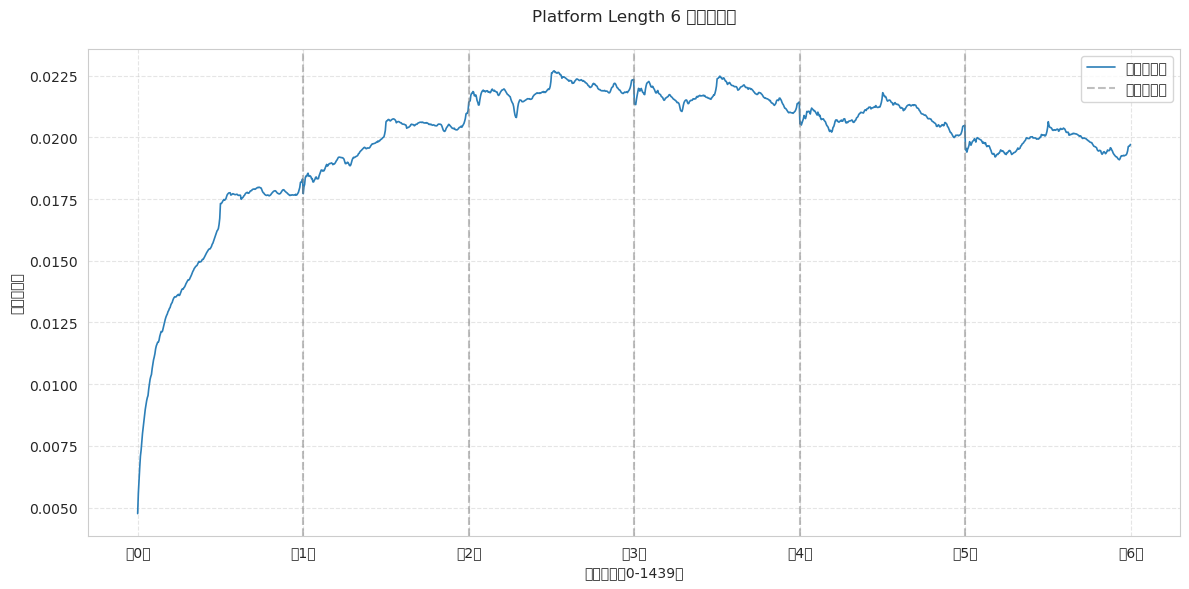

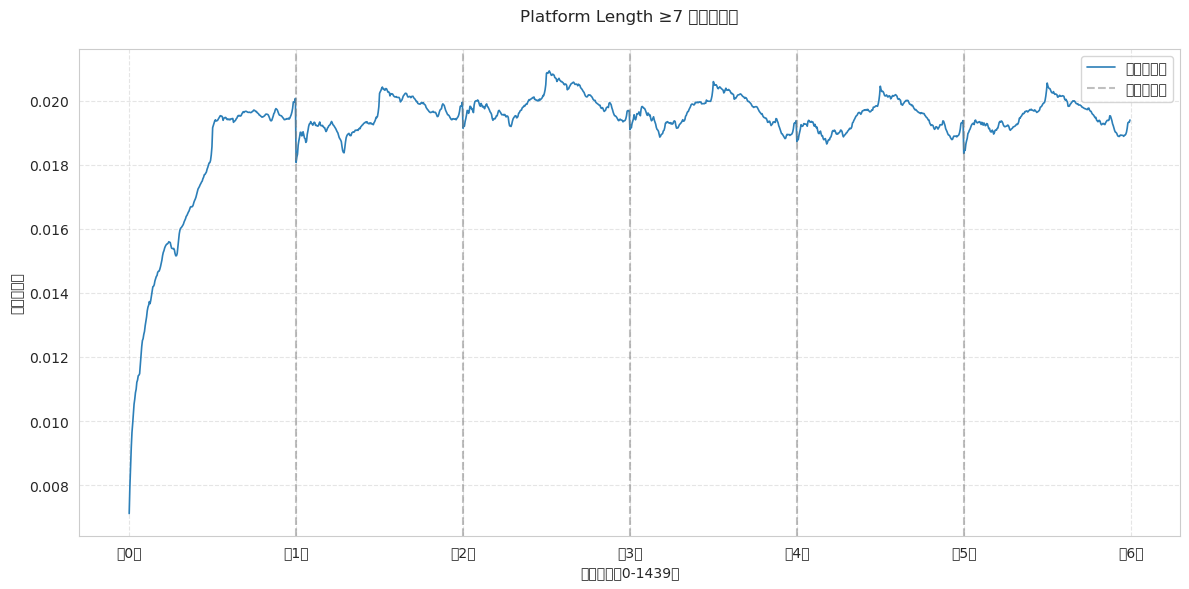

In [96]:
'''
Task3:记突破平台的时间是0，记录6天内的平均收益 根据平台长度分类绘制分钟收益曲线
'''

with Pool(64, initializer = init_worker, initargs=(long_table,)) as p:
    # 直接使用 stock_process，不需要 partial
    res_lst = list(tqdm(p.imap(stock_process, stock_list), total=len(stock_list)))
final = {'2':[[],0],'3':[[],0],'4':[[],0],'5':[[],0],'6':[[],0],'≥7':[[],0]}
for t in res_lst:
    for key, values in t.items():
        final[key][0].extend(values[0])  # 合并列表
        final[key][1] += values[1]       # 累加计数
GLOBAL_RETURN_DATA = return_data  # 赋值一次
# 提取数据并绘图
return_ppdd = pd.DataFrame(0,index = range(240*6),columns = ['2','3','4','5','6','≥7'])
for i in ['2', '3', '4', '5', '6', '≥7']:
    s = minute_data_extract(final[i])
    return_ppdd[i] = s
    plot_minute_return_curve(s, title=f"Platform Length {i} 的收益曲线")
    plt.show()

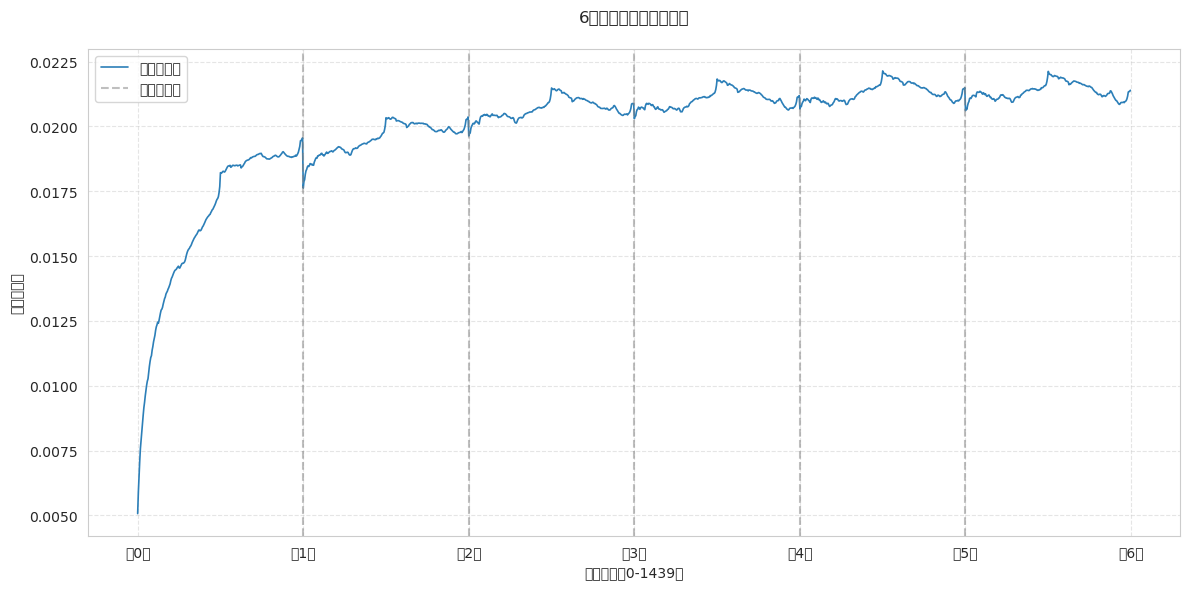

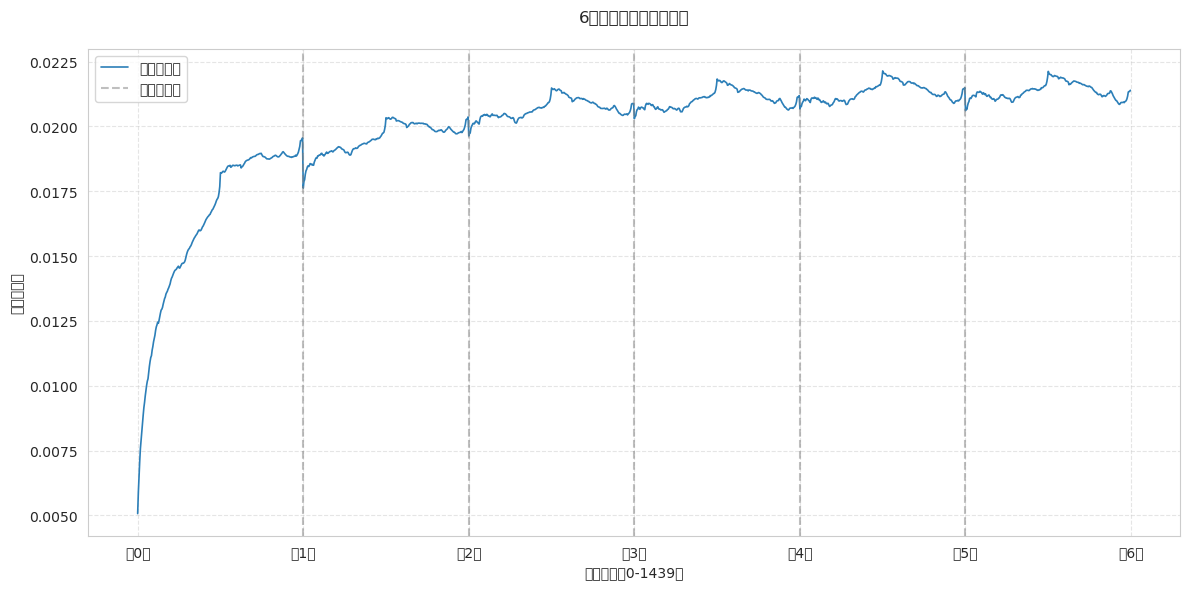

In [101]:
'''Task4 记突破平台的时间是0，记录6天内的平均收益 绘制分钟收益曲线'''
gross_res = [[],0]
for i,li in final.items():
    gross_res[0].extend(li[0])
    gross_res[1] += li[1]
ss = minute_data_extract(gross_res)
plot_minute_return_curve(ss)


In [116]:
ss.tail(10)


1430   -0.000022
1431    0.000037
1432    0.000014
1433    0.000029
1434    0.000063
1435    0.000102
1436    0.000158
1437    0.000019
1438    0.000000
1439    0.000046
dtype: float64

In [97]:
return_ppdd

,2,3,4,5,6,≥7
0,0.005913,0.004195,0.004320,0.003913,0.004754,0.007111
1,0.000817,0.000786,0.000817,0.000830,0.000820,0.000844
2,0.000769,0.000607,0.000590,0.000583,0.000529,0.000612
3,0.000767,0.000571,0.000488,0.000607,0.000516,0.000601
4,0.000560,0.000503,0.000473,0.000504,0.000451,0.000458
...,...,...,...,...,...,...
1435,0.000084,0.000111,0.000091,0.000093,0.000099,0.000118
1436,0.000163,0.000154,0.000152,0.000145,0.000175,0.000166
1437,0.000017,0.000018,0.000020,0.000023,0.000020,0.000019
1438,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


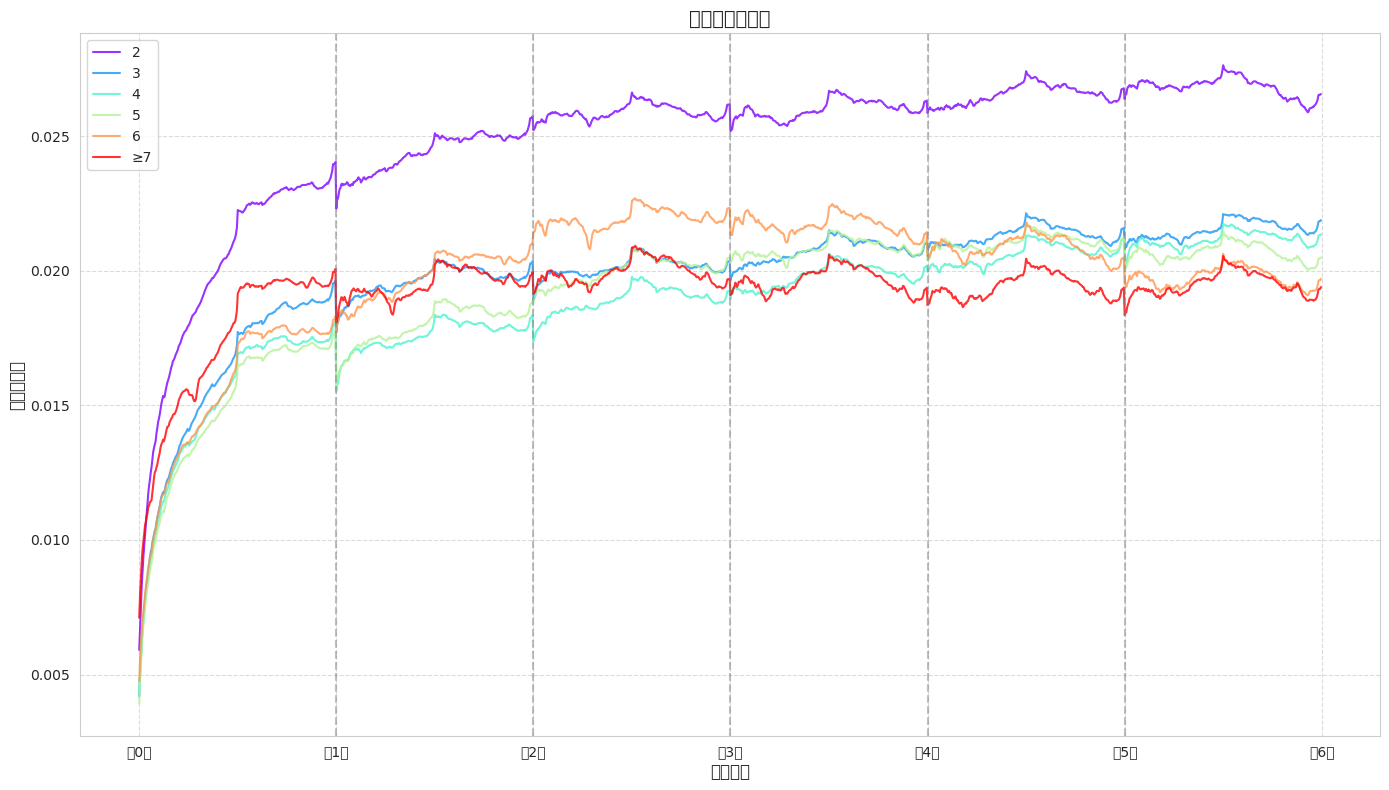

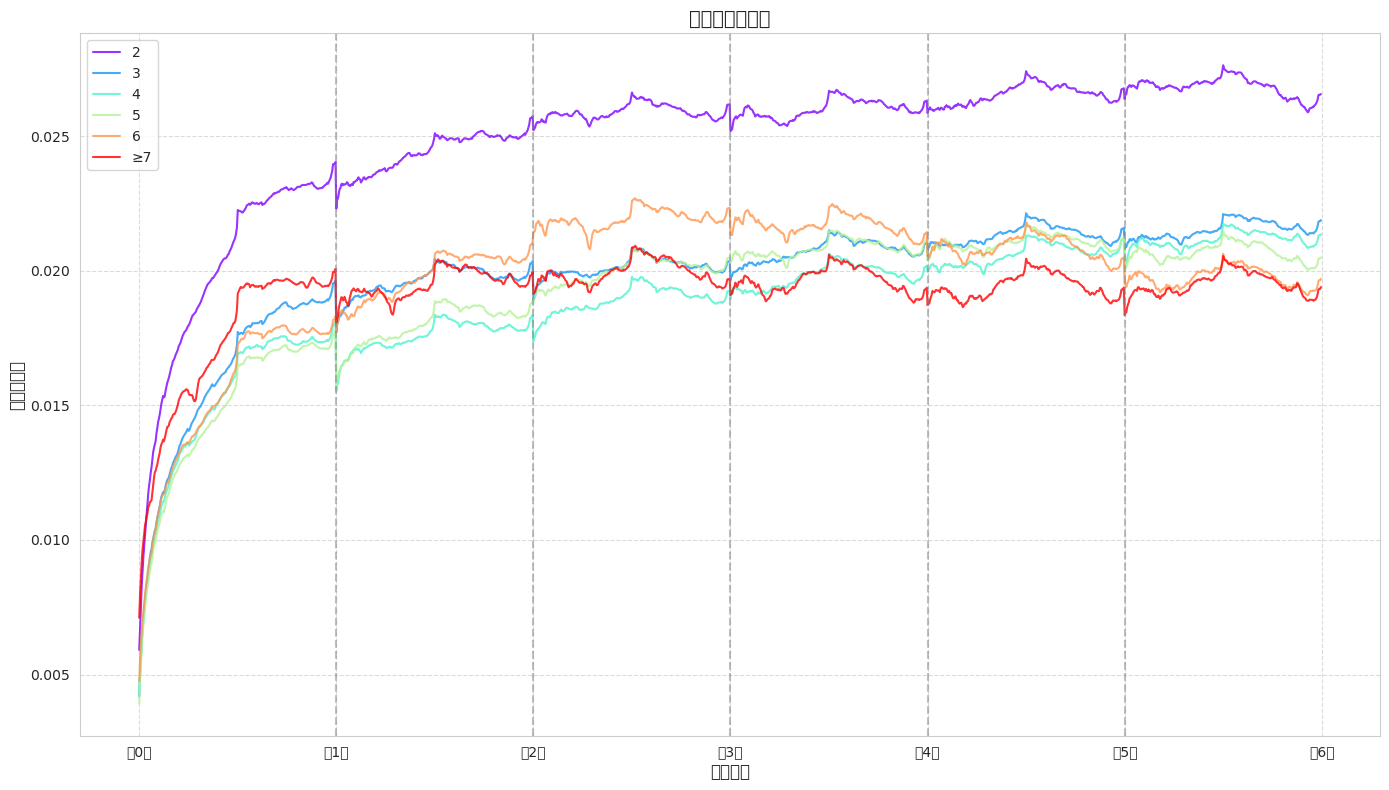

In [109]:
plot_multi_columns_return(return_ppdd)